# Import packages

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np
import scipy.stats as stats
import shap
from pathlib import Path

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from matplotlib import rcParams
from cycler import cycler
from sklearn.inspection import permutation_importance
from tqdm import trange
from statsmodels.stats.multitest import multipletests



rcParams.update({'figure.autolayout': True})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
linestyle_cycler =  [
     'solid','dotted', 'dashed','dashdot',
     (0, (1, 1)),(0, (1, 1))]
plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'c', 'k']) 
                           + cycler('linestyle', linestyle_cycler)))

## Choose type of mode

In [16]:
mode = 'positive'
#mode = 'negative'

Path(f'../results/{mode}').mkdir(exist_ok=True)

## Load lipid data

In [17]:
lipid_data_df = pd.read_csv(f'all_data_{mode}.csv')

In [18]:
lipid_data_df.isna().any().value_counts()

True     174
False    135
dtype: int64

In [19]:
print(lipid_data_df.isna().any().sort_values(ascending=False))

PE 16:0_18:2                True
TG 14:0_15:0_16:0           True
SM d18:1_16:1               True
SM d32:1                    True
SM d39:1                    True
SM d43:2                    True
TG 10:0_16:0_18:2           True
TG 12:0_14:0_15:0           True
TG 12:0_14:0_16:0           True
TG 12:0_16:1_18:1           True
TG 12:0_16:1_18:2           True
TG 12:0_18:3_20:4           True
TG 14:0_14:0_15:0           True
TG 14:0_14:0_16:0           True
TG 14:0_15:0_16:1           True
PC 42:4                     True
TG 14:0_18:2_18:2           True
TG 14:0_18:2_18:3           True
TG 15:0_16:0_16:1           True
TG 15:0_16:0_18:1           True
TG 15:0_18:1_18:2           True
TG 15:0_18:2_18:2           True
TG 15:1_18:2_18:3           True
TG 16:0_16:0_18:1           True
TG 16:0_16:1_25:0           True
TG 16:0_17:1_18:1           True
TG 16:0_18:0_18:0           True
TG 16:0_18:1_20:4           True
PS 18:0_22:6                True
PS 18:0_20:4                True
PS 18:0_18

In [20]:
lipid_data_df.drop(columns=['Person', 'Date']).describe()

,CE 14:0,CE 16:0,CE 16:1,CE 18:0,CE 20:0,CE 20:3,CE 20:4,CE 20:5,CE 22:6,Cer d18:1_16:0,Cer d18:1_18:0,Cer d18:1_20:0,Cer d18:1_22:0,Cer d18:1_24:0,Cer d18:1_24:1,Cholesterol (Ovine),DG 16:0_16:0,DG 16:0_18:1,DG 16:0_18:2,DG 18:0_16:0,DG 18:0_18:0,DG 18:0_18:1,DG 18:0_20:4,DG 18:1_18:1,DG 18:1_18:2,DG 18:1_20:4,DG 18:1_22:6,DG 20:0_18:1,LPC 14:0-SN1,LPC 14:0-SN2,LPC 15:0-SN1,LPC 15:0-SN2,LPC 16:0-SN1,LPC 16:0-SN2,LPC 16:1-SN1,LPC 16:1-SN2,LPC 17:0-SN1,LPC 18:0-SN1,LPC 18:0-SN2,LPC 18:1-SN1,LPC 18:1-SN2,LPC 18:2-SN1,LPC 18:2-SN2,LPC 18:3-SN1,LPC 18:3-SN2,LPC 19:0-SN2,LPC 19:0-SN1,LPC 19:1-SN1,LPC 20:0-SN1,LPC 20:0-SN2,LPC 20:1-SN1,LPC 20:2-SN1,LPC 20:3-SN1,LPC 20:3-SN2,LPC 20:4-SN1,LPC 20:4-SN2,LPC 20:5-SN1,LPC 20:5-SN2,LPC 22:0-SN1,LPC 22:4-SN2,LPC 22:4-SN1,LPC 22:5-SN1,LPC 22:5-SN2,LPC 22:6-SN1,LPC 22:6-SN2,LPC 24:0-SN1,LPE 16:0,LPE 18:0,LPE 18:1,LPS 18:0,PC 14:0_14:0,PC 14:0_16:0,PC 16:0_18:0,PC 16:0_18:1,PC 16:0_20:4,PC 16:1_16:1 Cis,PC 18:0_14:0,PC 18:0_18:1,PC 18:0_20:4,PC 18:0_22:6,PC 18:1_14:0,PC 18:1_18:1 Cis,PC 18:3_18:3 Cis,PC 20:4_20:4 Cis,PC 22:6_22:6 Cis,PC 30:1,PC 31:0,PC 32:3,PC 33:1,PC 33:2,PC 34:3,PC 34:4,PC 34:5,PC 35:1,PC 35:2,PC 35:3,PC 35:4,PC 36:5,PC 37:2,PC 37:4,PC 37:5,PC 38:1,PC 38:2,PC 38:3,PC 38:5,PC 38:6,PC 39:6,PC 40:1,PC 40:2,PC 40:4,PC 40:5,PC 40:6,PC 40:7,PC 40:9,PC 42:10,PC 42:4,PC 42:5,PC 42:9,PC 44:5,PC O-26:0,PC O-32:1,PC O-32:2,PC O-34:0,PC O-34:1,PC O-34:2,PC O-34:3,PC O-35:3,PC O-36:1,PC O-36:2,PC O-36:3,PC O-36:4,PC O-36:5,PC O-37:5,PC O-38:4,PC O-40:4,PC O-40:5,PC O-40:6,PC O-40:7,PC O-42:2,PC O-42:4,PC O-42:5,PC O-42:6,PC O-44:5,PC O-44:6,PC O-44:7,PC O-46:5,PC O-46:7,PC O-46:8,PC P-18:0_20:4,PE 16:0_16:0,PE 16:0_18:1,PE 16:0_18:2,PE 16:0_20:4,PE 16:0_22:6,PE 16:1_16:1,PE 18:0_18:1,PE 18:0_20:4,PE 18:0_22:6,PE 18:1_18:1 Cis,PE 18:2_18:2,PE 18:3_18:3,PE P-18:0_18:1,PE P-18:0_20:4,PE P-18:0_22:6,PI 36:4,PI 18:0_20:4,PI 18:1_18:1,PS 16:0_18:1,PS 16:0_20:4,PS 18:0_18:1,PS 18:0_18:2,PS 18:0_20:4,PS 18:0_22:6,SM d18:1_16:0,SM d18:1_16:1,SM d18:1_18:0,SM d18:1_18:1,SM d18:1_24:0,SM d18:1_24:1,SM d31:1,SM d32:0,SM d32:1,SM d32:2,SM d33:1,SM d33:2,SM d34:0,SM d35:1,SM d35:2,SM d36:0,SM d36:3,SM d37:1,SM d38:1,SM d38:2,SM d38:3,SM d39:1,SM d40:1,SM d40:2,SM d41:1,SM d41:2,SM d41:3,SM d42:3,SM d42:4,SM d43:1,SM d43:2,SM d43:3,SM d44:1,SM d44:2,SM d44:3,TG 10:0_14:0_16:0,TG 10:0_16:0_18:2,TG 12:0_14:0_15:0,TG 12:0_14:0_16:0,TG 12:0_16:0_16:1,TG 12:0_16:1_18:1,TG 12:0_16:1_18:2,TG 12:0_18:3_20:4,TG 13:0_16:1_16:1,TG 14:0_14:0_15:0,TG 14:0_14:0_16:0,TG 14:0_15:0_16:0,TG 14:0_15:0_16:1,TG 14:0_16:0_16:1,TG 14:0_16:0_18:1,TG 14:0_16:1_18:1,TG 14:0_18:2_18:2,TG 14:0_18:2_18:3,TG 15:0_16:0_16:1,TG 15:0_16:0_18:1,TG 15:0_16:1_16:1,TG 15:0_16:1_18:1,TG 15:0_18:1_18:2,TG 15:0_18:2_18:2,TG 15:1_18:2_18:3,TG 16:0_16:0_18:1,TG 16:0_16:1_18:1,TG 16:0_16:1_25:0,TG 16:0_17:1_18:1,TG 16:0_18:0_18:0,TG 16:0_18:1_18:2,TG 16:0_18:1_20:4,TG 16:0_18:1_22:0,TG 16:0_18:2_18:2,TG 16:0_20:4_22:6,TG 16:1_16:0_18:2,TG 16:1_16:1_16:1,TG 16:1_18:2_18:2,TG 18:1_18:1_18:2,TG 18:1_18:1_20:4,TG 18:1_18:1_22:0,TG 18:1_18:2_20:4,TG 18:1_18:2_22:0,TG 18:1_20:4_20:4,TG 18:2_18:2_18:2,TG 18:2_18:2_20:5,TG 18:2_18:3_20:5,TG 18:2_20:4_20:5,TG 8:0_16:0_18:1,TG 8:0_16:0_18:2,TG 8:0_16:1_18:2,TG 9:0_16:1_18:1,CE 17:0,DG 16:0_16:1,PC 16:0_16:0,PC 18:0_18:2,PC 18:2_18:2 Cis,PC 30:0,PC 39:4,PC O-32:0,PE 18:1_18:1 Trans,PI 16:0_18:1,PS 16:0_16:0,TG 10:0_14:1_16:0,TG 14:1_18:2_18:3,TG 15:0_16:1_18:2,TG 15:0_18:2_18:3,TG 16:0_16:0_24:0,TG 16:0_18:1_18:1,TG 16:1_16:1_18:1,TG 16:1_18:2_18:3,TG 16:2_18:2_18:3,TG 17:0_18:1_18:1,TG 17:1_18:1_18:2,TG 18:0_18:0_18:0,TG 18:1_18:1_18:1,TG 18:1_18:1_20:0,TG 18:1_18:2_18:2,TG 18:1_18:2_24:0,TG 18:2_18:2_18:3,TG 18:2_18:3_18:3,DG 14:0_16:0,DG 18:2_18:2,LPC 17:0-SN2,PC 18:0_16:0,PC 18:1_16:0,PC 18:1_18:0,PC 18:2_18:2 Cis (DLPC),TG 10:0_18:2_18:2,TG 11:0_14:1_16:0,TG 12:0_18:2_18:2,TG 16:0_18:2_22:6,TG 18:2_20:4_22:6,LPC 22:1-SN1,PC 40:3,PC O-46:6,TG 12:0_18:2_18:3,TG 8:0_12:0_16:0
count,28.000000,42.000000,5

# Remove lipids that does not appear in every person or type

In [21]:
lipid_data_df = lipid_data_df.drop(lipid_data_df[(lipid_data_df['Blood Type'] == 'Blood EDTA') &
                                             (lipid_data_df['Date'] == 210702)].index)
lipid_data_df = lipid_data_df.reset_index()
lipid_data_df_without_na = lipid_data_df.dropna(axis='columns')
plasma = lipid_data_df[lipid_data_df['Blood Type'] == 'Plasma'].dropna(axis='columns')
serum = lipid_data_df[lipid_data_df['Blood Type'] == 'Serum'].dropna(axis='columns')
blood_edta = lipid_data_df[lipid_data_df['Blood Type'] == 'Blood EDTA'].dropna(axis='columns')
dbs_venous = lipid_data_df[lipid_data_df['Blood Type'] == 'DBS - Venous'].dropna(axis='columns')
dbs_finger = lipid_data_df[lipid_data_df['Blood Type'] == 'DBS - Finger'].dropna(axis='columns')

blood_type_dict = {'Plasma': plasma, 
              'Serum':serum,
              'Blood EDTA': blood_edta,
              'DBS - Venous': dbs_venous,
              'DBS - Finger': dbs_finger}

In [22]:
plasma_without_drop = lipid_data_df[lipid_data_df['Blood Type'] == 'Plasma']
serum_without_drop = lipid_data_df[lipid_data_df['Blood Type'] == 'Serum']
blood_edta_without_drop = lipid_data_df[lipid_data_df['Blood Type'] == 'Blood EDTA']
dbs_venous_without_drop = lipid_data_df[lipid_data_df['Blood Type'] == 'DBS - Venous']
dbs_finger_without_drop = lipid_data_df[lipid_data_df['Blood Type'] == 'DBS - Finger']
blood_type_dict_without_drop = {'Plasma': plasma_without_drop, 
              'Serum':serum_without_drop,
              'Blood EDTA': blood_edta_without_drop,
              'DBS - Venous': dbs_venous_without_drop,
              'DBS - Finger': dbs_finger_without_drop}

# Pair-wise scatter plots

In [23]:
# The parplot visualisation is not very helpful and takes a while to compute. Uncomment the next two lines 
# if it is needed.

#pairplot = sns.pairplot(lipid_data_df_without_na, y_vars=["Person", 'Blood Type', 'Date'], hue='Blood Type')
# pairplot.savefig(f'../results/{mode}/pair-plot.pdf')

# Dimension reduction

## PCA

In [24]:
Path(f'../results/{mode}/visualisation').mkdir(exist_ok=True)

In [25]:
pca = PCA(n_components=2)
print(len(lipid_data_df_without_na))
if mode == 'positive':
    tmp_data = lipid_data_df_without_na.drop(lipid_data_df_without_na[\
                (lipid_data_df_without_na['Person'] == 4)].index)
    lipid_data_df_without_na_standardised = (tmp_data.drop(
        columns=['Person', 'Blood Type', 'Date', 'index'])-
                                tmp_data.drop(columns=['Person', 'Blood Type', 'Date', 'index']).mean())/\
    tmp_data.drop(columns=['Person', 'Blood Type', 'Date', 'index']).std()
else:
    lipid_data_df_without_na_standardised = (lipid_data_df_without_na.drop(
        columns=['Person', 'Blood Type', 'Date', 'index'])-
                                lipid_data_df_without_na.drop(
        columns=['Person', 'Blood Type', 'Date', 'index']).mean())/\
    lipid_data_df_without_na.drop(columns=['Person', 'Blood Type', 'Date', 'index']).std()
projected_lipid_data = pca.fit_transform(lipid_data_df_without_na_standardised)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

56
[0.44522281 0.18284761]
0.6280704136780169


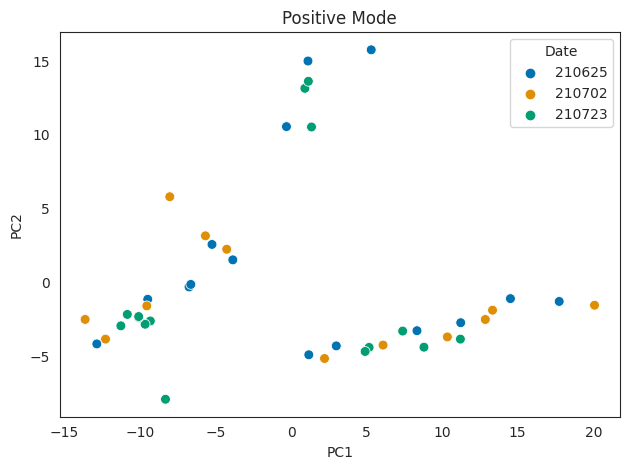

In [26]:
pc_df = pd.DataFrame(data = projected_lipid_data, columns = ['PC1', 'PC2'])
pc_df['Blood Type'] = lipid_data_df_without_na['Blood Type']
pc_df['Date'] = lipid_data_df_without_na['Date']

scatterplot_persons = sns.scatterplot(x="PC1", y="PC2",
  data=pc_df, 
  hue='Date', # color by cluster
  legend=True,
s= 50, palette='colorblind',) # specify the point size
figure = scatterplot_persons.get_figure()
plt.title(f'{mode.capitalize()} Mode')
figure.savefig(f'../results/{mode}/visualisation/date_pca.pdf')

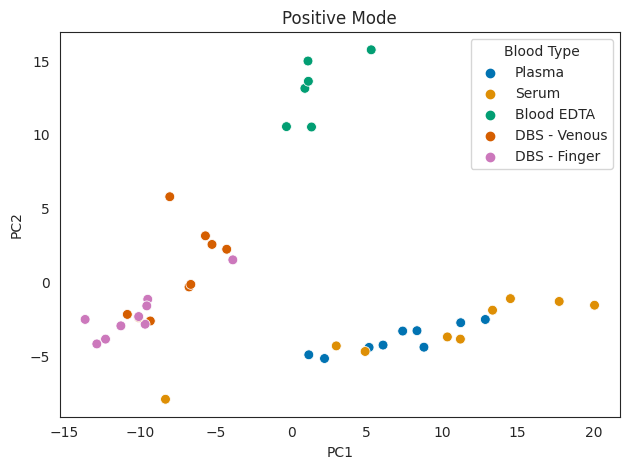

In [27]:
scatterplot_type = sns.scatterplot( x="PC1", y="PC2",
  data=pc_df,  
  hue='Blood Type', # color by cluster
  legend=True,
  s= 50, palette='colorblind',) # specify the point size
figure = scatterplot_type.get_figure()
plt.title(f'{mode.capitalize()} Mode')
figure.savefig(f'../results/{mode}/visualisation/type_pca.pdf')

## t-SNE

In [46]:
tsne = TSNE(n_components=2, init='pca', learning_rate=50)
projected_lipid_data = tsne.fit_transform(lipid_data_df_without_na_standardised)

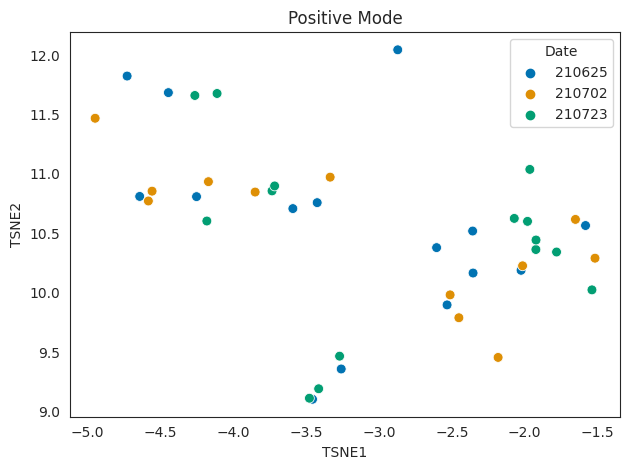

In [47]:
pc_df = pd.DataFrame(data = projected_lipid_data , 
        columns = ['TSNE1', 'TSNE2'])
pc_df['Blood Type'] = lipid_data_df_without_na['Blood Type']
pc_df['Date'] = lipid_data_df_without_na['Date']
scatterplot_persons = sns.scatterplot( x="TSNE1", y="TSNE2",
  data=pc_df,  
  hue='Date', # color by cluster
  legend=True,
  s=50,
  palette='colorblind') # specify the point size
figure = scatterplot_persons.get_figure()
plt.title(f'{mode.capitalize()} Mode')
figure.savefig(f'../results/{mode}/visualisation/date_tsne.pdf')

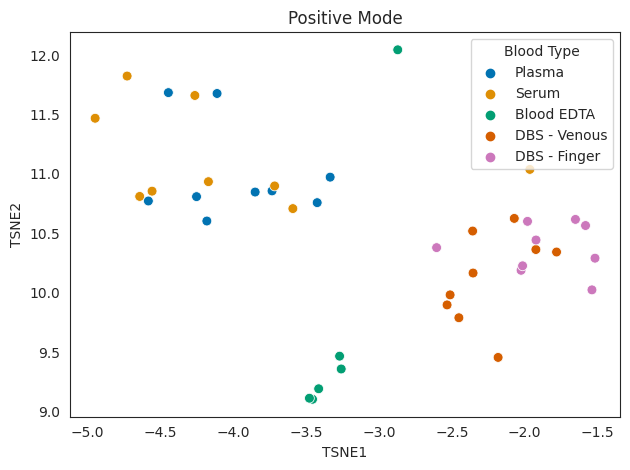

In [48]:
scatterplot_type = sns.scatterplot(x="TSNE1", y="TSNE2",
  data=pc_df, 
  hue='Blood Type', # color by cluster
  legend=True,
palette='colorblind', s=50) # specify the point size
fig = scatterplot_type.get_figure()
plt.title(f'{mode.capitalize()} Mode')
fig.savefig(f'../results/{mode}/visualisation/type_tsne.pdf')

# Statistical tests

In [49]:
p_border = 0.05
statistic_root_path = f'../results/{mode}/statistic/'
Path(statistic_root_path, 'friedman').mkdir(parents=True, exist_ok=True)
Path(statistic_root_path, 'kruskal-wallis').mkdir(parents=True, exist_ok=True)

## Friedman test to test differences in lipid distributions over timepoints per blood type

invalid value encountered in double_scalars


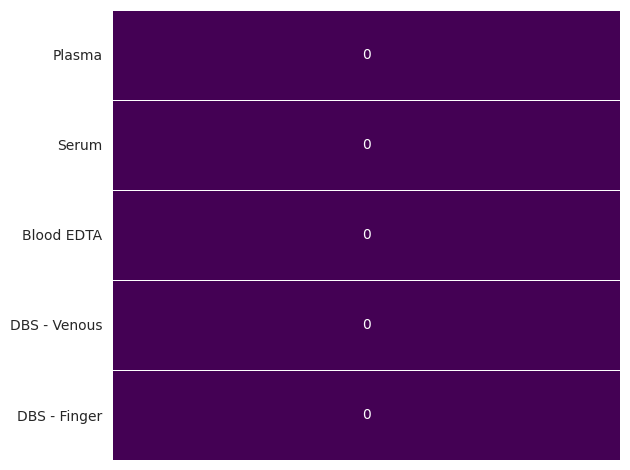

In [50]:
column = []
for key, value in blood_type_dict.items():
    p_value_list = list()
    lipid_counter = 0
    counter = 0
    dates = value['Date'].unique()
    if len(dates) == 3:
        first_date_data = value[value['Date'] == dates[0]]
        second_date_data = value[value['Date'] == dates[1]]
        third_date_data = value[value['Date'] == dates[2]]
        for k in value.drop(columns=['Person', 'Blood Type', 'Date', 'index']).keys(): 
            lipid_counter += 1
            _, pvalue = stats.friedmanchisquare(first_date_data[k].dropna(), second_date_data[k].dropna(),
                                                third_date_data[k].dropna())
            p_value_list.append(pvalue)
        _, adjusted_p_values, _, _ = multipletests(p_value_list, method='fdr_bh')
        for adjusted_p_value in adjusted_p_values:
            if adjusted_p_value <= p_border:
                counter += 1
    else:
        first_date_data = value[value['Date'] == dates[0]]
        second_date_data = value[value['Date'] == dates[1]]
        for k in value.drop(columns=['Person', 'Blood Type', 'Date', 'index']).keys(): 
            lipid_counter += 1
            _, pvalue = stats.wilcoxon(first_date_data[k].dropna(), second_date_data[k].dropna())   
            p_value_list.append(pvalue)
        _, adjusted_p_values, _, _ = multipletests(p_value_list, method='fdr_bh')
        for adjusted_p_value in adjusted_p_values:
            if adjusted_p_value <= p_border:
                counter += 1
    column.append(counter)

sns.heatmap(np.asarray(column)[:, np.newaxis],  linewidths=0.5, cmap='viridis',
            yticklabels=blood_type_dict.keys(), xticklabels=[], fmt='g', annot=True, cbar=False)
plt.savefig(f'{statistic_root_path}friedman/friedmann_test_blood_type.pdf')

## Friedman test split up per person

In [51]:
second_date_data


,index,Date,Blood Type,Person,CE 16:1,CE 18:0,CE 20:4,Cer d18:1_16:0,Cer d18:1_18:0,Cer d18:1_20:0,Cer d18:1_22:0,Cer d18:1_24:0,Cer d18:1_24:1,Cholesterol (Ovine),DG 16:0_16:0,DG 16:0_18:1,DG 18:0_16:0,DG 18:0_18:0,DG 18:0_18:1,DG 18:1_18:1,DG 18:1_18:2,DG 20:0_18:1,LPC 14:0-SN1,LPC 14:0-SN2,LPC 15:0-SN1,LPC 15:0-SN2,LPC 16:0-SN1,LPC 16:0-SN2,LPC 16:1-SN1,LPC 16:1-SN2,LPC 17:0-SN1,LPC 18:0-SN1,LPC 18:0-SN2,LPC 18:1-SN1,LPC 18:1-SN2,LPC 18:2-SN1,LPC 18:2-SN2,LPC 18:3-SN1,LPC 19:0-SN2,LPC 19:0-SN1,LPC 19:1-SN1,LPC 20:0-SN1,LPC 20:0-SN2,LPC 20:1-SN1,LPC 20:2-SN1,LPC 20:3-SN1,LPC 20:4-SN1,LPC 20:4-SN2,LPC 20:5-SN1,LPC 20:5-SN2,LPC 22:0-SN1,LPC 22:4-SN2,LPC 22:4-SN1,LPC 22:5-SN1,LPC 22:5-SN2,LPC 22:6-SN1,LPC 22:6-SN2,LPC 24:0-SN1,LPE 16:0,LPE 18:0,LPE 18:1,PC 14:0_14:0,PC 16:0_18:0,PC 16:0_18:1,PC 16:0_20:4,PC 16:1_16:1 Cis,PC 18:0_14:0,PC 18:0_18:1,PC 18:0_20:4,PC 18:1_14:0,PC 18:1_18:1 Cis,PC 18:3_18:3 Cis,PC 20:4_20:4 Cis,PC 30:1,PC 31:0,PC 32:3,PC 33:1,PC 33:2,PC 34:3,PC 34:4,PC 34:5,PC 35:1,PC 35:2,PC 35:3,PC 35:4,PC 36:5,PC 37:2,PC 37:4,PC 37:5,PC 38:1,PC 38:2,PC 38:3,PC 38:5,PC 38:6,PC 39:6,PC 40:1,PC 40:2,PC 40:4,PC 40:5,PC 40:6,PC 40:7,PC 42:10,PC 42:4,PC 42:5,PC 44:5,PC O-32:1,PC O-32:2,PC O-34:0,PC O-34:1,PC O-34:3,PC O-35:3,PC O-36:1,PC O-36:2,PC O-36:3,PC O-36:4,PC O-36:5,PC O-37:5,PC O-38:4,PC O-40:4,PC O-40:5,PC O-40:7,PC O-42:2,PC O-42:5,PC O-42:6,PC O-44:5,PC O-44:6,PC O-44:7,PC O-46:5,PC O-46:7,PC O-46:8,PC P-18:0_20:4,PE 16:0_16:0,PE 16:0_18:1,PE 16:0_18:2,PE 16:0_20:4,PE 16:0_22:6,PE 16:1_16:1,PE 18:0_18:1,PE 18:0_20:4,PE 18:0_22:6,PE 18:1_18:1 Cis,PE 18:2_18:2,PE P-18:0_18:1,PE P-18:0_20:4,PI 18:0_20:4,PI 18:1_18:1,PS 16:0_18:1,PS 16:0_20:4,PS 18:0_18:2,PS 18:0_20:4,PS 18:0_22:6,SM d18:1_16:0,SM d18:1_18:0,SM d18:1_18:1,SM d18:1_24:0,SM d18:1_24:1,SM d31:1,SM d32:0,SM d32:1,SM d32:2,SM d33:1,SM d33:2,SM d34:0,SM d35:1,SM d35:2,SM d36:0,SM d36:3,SM d37:1,SM d38:1,SM d38:2,SM d38:3,SM d40:1,SM d40:2,SM d41:1,SM d41:2,SM d41:3,SM d42:3,SM d42:4,SM d43:1,SM d43:2,SM d43:3,SM d44:1,SM d44:2,SM d44:3,TG 10:0_14:0_16:0,TG 12:0_16:0_16:1,TG 13:0_16:1_16:1,TG 14:0_16:0_16:1,TG 14:0_16:0_18:1,TG 14:0_16:1_18:1,TG 15:0_16:1_16:1,TG 15:0_16:1_18:1,TG 16:0_16:1_18:1,TG 16:0_18:1_18:2,TG 16:0_18:2_18:2,TG 16:1_16:1_16:1,TG 18:1_18:1_18:2,TG 18:1_18:1_22:0,TG 18:1_18:2_22:0,TG 8:0_16:0_18:1,TG 9:0_16:1_18:1
8,9,210702,DBS - Finger,1,2.984212,0.468473,22.121374,0.871077,0.347586,0.346847,0.000000,3.098482,7.863724,413.794984,0.311031,2.733478,0.251700,0.534559,0.965080,2.982765,1.316276,0.032537,0.400716,0.059665,0.239009,0.032991,21.465727,3.386686,0.314028,0.041411,0.434037,10.780345,1.225250,6.820188,1.324546,11.365845,1.732166,0.098168,0.016127,0.040557,0.013349,0.161441,0.006601,0.081403,0.075155,0.516560,1.532554,0.476979,0.114195,0.033130,0.031651,0.018001,0.021989,0.062866,0.017142,0.359052,0.082937,0.053696,0.565283,0.864191,0.948530,0.064346,3.944564,99.661155,62.514533,2.086073,14.117072,32.704130,32.711110,4.636057,103.386082,0.000000,0.228670,0.066415,0.382998,0.013072,1.001409,1.582790,3.239356,0.549287,0.021449,1.221328,3.196762,0.233148,0.252173,6.412551,0.201716,0.942845,0.137510,0.168021,0.826958,12.871542,10.816587,20.832949,0.279970,0.011452,0.021562,0.270754,1.245544,0.284092,0.751670,0.045208,0.014129,0.020998,0.003580,0.420551,0.120314,0.502633,2.356170,2.372609,0.085520,0.740421,0.282139,0.941655,2.438994,2.401695,0.122857,1.517845,0.102149,0.204190,0.406776,0.021746,0.082054,0.045315,0.105674,0.037874,0.014827,0.007404,0.016042,0.005092,0.695743,0.510005,12.200848,4.574858,9.447213,4.130314,0.078870,3.874942,11.073756,1.398954,5.377696,0.465343,1.942418,15.160912,102.003069,15.133973,1.111833,0.332108,1.721783,23.549914,11.254662,64.438706,13.659927,7.426765,19.672358,34.352241,0.236568,0.233719,0.023762,0.572741,4.319608,0.122869,4.911990,2.843383,0.301600,0.677712,0.373168,1.125596,9.199403,4.767490,0.191879,21.016811,14.376033,4.489952,3.805933,0.539397,18.053180,1.083580,0.565147,0.781257,0.297030

In [ ]:
matrix = []
for key, value in blood_type_dict_without_drop.items():
    row = []
    for person_idx in range(1, 5):
        p_value_list = list()
        person_data = value[value['Person'] == person_idx]
        dates = person_data['Date'].unique()
        if len(dates) == 3:
            first_date_data = person_data[person_data['Date'] == dates[0]]\
            .drop(columns=['Person', 'Blood Type', 'Date', 'index'])
            second_date_data = person_data[person_data['Date'] == dates[1]]\
            .drop(columns=['Person', 'Blood Type', 'Date', 'index'])
            third_date_data = person_data[person_data['Date'] == dates[2]].drop(columns=['Person', \
                                                                             'Blood Type', 'Date', 'index'])

            _, pvalue = stats.friedmanchisquare(first_date_data.dropna(axis='columns'),
                                                second_date_data.dropna(axis='columns'),
                                                third_date_data.dropna(axis='columns'))
        else:
            first_date_data = person_data[person_data['Date'] == dates[0]].\
            drop(columns=['Person', 'Blood Type', 'Date', 'index']).dropna(axis='columns')
            first_date_data = np.asarray(first_date_data).flatten()
            second_date_data = person_data[person_data['Date'] == dates[1]].\
            drop(columns=['Person', 'Blood Type', 'Date', 'index']).dropna(axis='columns')
            second_date_data = np.asarray(second_date_data).flatten()
            print(np.around(second_date_data - first_date_data, 1))
            _, pvalue = stats.wilcoxon(first_date_data,
                                       second_date_data)   
        row.append(pvalue)
    matrix.append(row)

matrix = np.asarray(matrix)

_, adjusted_matrix, _, _ = multipletests(matrix.flatten(), method='fdr_bh')
adjusted_matrix = np.around(adjusted_matrix, 3)
adjusted_matrix = np.reshape(adjusted_matrix, (5, 4))
sns.heatmap(adjusted_matrix,  linewidths=0.5, cmap='viridis',
            yticklabels=blood_type_dict_without_drop.keys(), xticklabels=[*range(1,5)], annot=True, cbar=True)
plt.savefig(f'{statistic_root_path}friedman/friedmann_test_person.pdf')

# Compare intergroup differences

## Wilcoxon signed-rank test to test differences in lipid distribution between blood types. And visualise the number of differences with a heatmap.

In [13]:
Path(f'{statistic_root_path}wilcoxon').mkdir(parents=True, exist_ok=True)

NameError: name 'statistic_root_path' is not defined

In [14]:
matrix = []
for first_key, first_value in blood_type_dict.items():
    row = []
    for second_key, second_value in blood_type_dict.items():
        
        counter = 0
        p_value_list = list()
        lipid_counter = 0
        if first_key != second_key:
            if len(first_value['Date'].unique()) == 2 or len(second_value['Date'].unique()) == 2:
                tmp_first_value = first_value.drop(first_value[first_value['Date'] == 210702].index)
                tmp_second_value = second_value.drop(second_value[second_value['Date'] == 210702].index)
                for k in first_value.drop(columns=['Person', 'Blood Type', 'Date', 'index']).keys():
                    lipid_counter += 1
                    statistics, pvalue = stats.wilcoxon(tmp_first_value[k],
                                                        tmp_second_value[k], mode='exact')
                    p_value_list.append(pvalue)

            else:
                for k in first_value.drop(columns=['Person', 'Blood Type', 'Date', 'index']).keys():
                    lipid_counter += 1
                    statistics, pvalue = stats.wilcoxon(first_value[k],
                                                        second_value[k], mode='exact')
                    p_value_list.append(pvalue)
            _, adjusted_p_values, _, _ = multipletests(p_value_list, method='fdr_bh')

            for adjusted_p_value in adjusted_p_values:
                if adjusted_p_value <= p_border:
                    counter += 1
        row.append(counter)
    matrix.append(row)

mask = np.zeros_like(matrix)
mask[np.triu_indices_from(mask, 1)] = True
sns.heatmap(matrix, annot=True, linewidths=0.5, cmap='viridis',
            xticklabels=blood_type_dict.keys(), yticklabels=blood_type_dict.keys(), fmt='g', mask=mask)
plt.xticks(rotation=45) 
plt.title(f'{mode.capitalize()} Mode')
plt.savefig(f'{statistic_root_path}wilcoxon/wilcoxon_signed_rank_test.pdf')

Exact p-value calculation does not work if there are ties. Switching to normal approximation.
Sample size too small for normal approximation.


NameError: name 'p_border' is not defined

## Pooled standard deviation per person

NameError: name 'statistic_root_path' is not defined

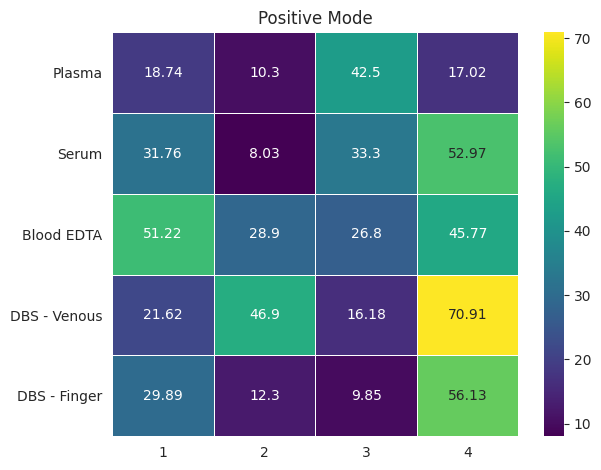

In [12]:
matrix = []
for key, value in blood_type_dict.items():
    row = []
    for person_idx in range(1, 5):
        person_data = value[value['Person'] == person_idx]
        pooled_variances_numerator = 0
        pooled_variances_denuminator = 0
        for k in person_data.drop(columns=['Person', 'Blood Type', 'Date', 'index']).keys():
            person_lipid = person_data[k]
            variance  = np.var(person_lipid, ddof=1)
            n_i = len(person_lipid)
            pooled_variances_numerator += (n_i -1) * variance
            pooled_variances_denuminator += (n_i - 1) 
        row.append(round(np.sqrt(pooled_variances_numerator/pooled_variances_denuminator), 2))
    matrix.append(row)


sns.heatmap(matrix,  linewidths=0.5, cmap='viridis',
            yticklabels=blood_type_dict.keys(), xticklabels=[*range(1,5)], fmt='g', annot=True, cbar=True)
plt.title(f'{mode.capitalize()} Mode')
plt.savefig(f'{statistic_root_path}variance_test_person.pdf')

## Pooled standard deviation for groups

NameError: name 'statistic_root_path' is not defined

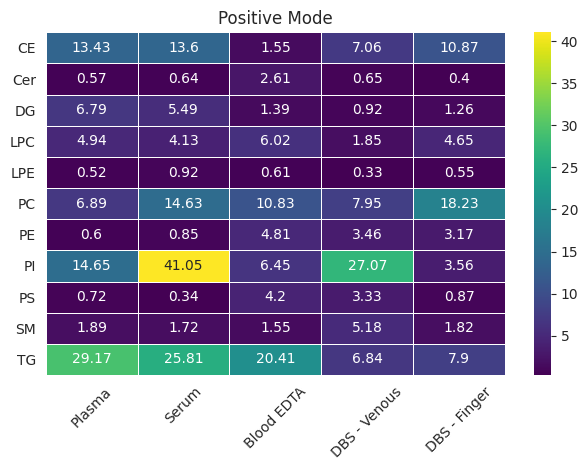

In [11]:
matrix = []
negative_lipid_groups = ['Cer', 'Hex', 'LPC', 'LPE', 'LPI', 'PA', 'PC', 'PE', 'PI', 'PG', 'PS', 'SM']
positive_lipid_groups = ['CE', 'Cer', 'DG', 'LPC', 'LPE', 'PC', 'PE', 'PI', 'PS' ,'SM', 'TG']
person_number = 1
lipid_groups = positive_lipid_groups if mode == 'positive' else negative_lipid_groups

for lipid_group in lipid_groups:
    row = []
    for key, value in blood_type_dict_without_drop.items():
        person_data = value[value['Person'] == person_number].dropna(axis='columns')
        pooled_variances_numerator = 0
        pooled_variances_denuminator = 0
        lipids_in_group = [lipid for lipid in person_data.columns if lipid_group in lipid]
        if lipids_in_group:
            for k in lipids_in_group:
                person_lipid = person_data[k]
                variance  = np.var(person_lipid, ddof=1)
                n_i = len(person_lipid)
                pooled_variances_numerator += (n_i - 1) * variance
                pooled_variances_denuminator += (n_i - 1)
            row.append(round(np.sqrt(pooled_variances_numerator/pooled_variances_denuminator),2))
        else:
            row.append(np.nan)
        
    matrix.append(row)
sns.heatmap(matrix,  linewidths=0.5, cmap='viridis',
            yticklabels=lipid_groups, xticklabels=blood_type_dict.keys() , fmt='g',annot=True, cbar=True)
plt.xticks(rotation=45)
plt.yticks(rotation=0) 
plt.title(f'{mode.capitalize()} Mode')

plt.savefig(f'{statistic_root_path}lipid_variance_test_p{person_number}.pdf')

# Train a random forest classifier

In [23]:
classification_root_path = f'../results/{mode}/classification/'
Path(f'{classification_root_path}multiclass').mkdir(parents=True, exist_ok=True)
Path(f'{classification_root_path}one_vs_rest').mkdir(parents=True, exist_ok=True)
Path(f'{classification_root_path}one_vs_one').mkdir(parents=True, exist_ok=True)

In [24]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 5)]
max_depth = [int(x) for x in np.linspace(10, 100, num = 5)]
max_depth.append(None)
min_samples_split = [2, 3, 5]
min_samples_leaf = [1, 2, 4]
lw = 2
# Create the grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
random_forest = RandomForestClassifier()
num_classes = len(lipid_data_df_without_na['Blood Type'].unique())
lipid_x = lipid_data_df_without_na.drop(columns=['Person', 'Blood Type', 'Date'])
label_encoder = LabelEncoder()
blood_type = label_encoder.fit_transform(lipid_data_df_without_na['Blood Type'])
logo = LeaveOneGroupOut()

## Multiclass

In [37]:
all_true_multiclass = []
all_prediction_multiclass = []

auroc_list = []
outer_groups = lipid_data_df_without_na['Person']
list_shap_values_multiclass = list()
list_test_sets = list()
list_permutation_imortance = list()
for train_index, test_index in logo.split(lipid_x, groups=outer_groups):
    train_val_data = lipid_x.iloc[train_index]
    test_data = lipid_x.iloc[test_index]
    blood_type_test_val = blood_type[train_index]
    blood_type_test = blood_type[test_index]
    inner_groups = outer_groups.iloc[train_index]
    grid_search = GridSearchCV(estimator = random_forest, param_grid = param_grid, 
                          cv = logo, n_jobs = -1, verbose = 1)
    clf = grid_search.fit(train_val_data,  blood_type_test_val, groups = inner_groups)
    
    #explaining model
    explainer = shap.TreeExplainer(clf.best_estimator_)
    shap_values = explainer.shap_values(test_data)
    #for each iteration we save the test_set index and the shap_values
    list_shap_values_multiclass.append(shap_values)
    list_test_sets.append(test_index)
    importance = permutation_importance(clf, test_data, blood_type_test)
    list_permutation_imortance.append(importance)
    
    # test stuff
    y_pred_proba = clf.predict_proba(test_data)
    y_pred = clf.predict(test_data)
    all_true_multiclass.extend(blood_type_test)
    all_prediction_multiclass.extend(y_pred_proba)
tmp = [permutation_imortance.importances_mean for permutation_imortance in list_permutation_imortance]
mean_importance_multiclass = np.mean(tmp, axis=0)
tmp = [permutation_imortance.importances_std for permutation_imortance in list_permutation_imortance]
std_importance_multiclass = np.mean(tmp, axis=0)

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits


## Permutation importance

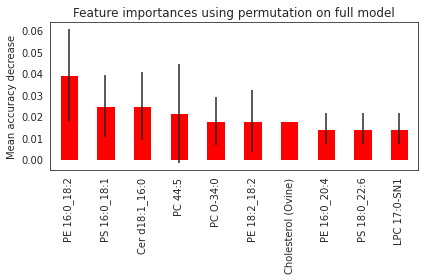

In [38]:
forest_importances = pd.Series(mean_importance_multiclass, index=lipid_x.keys())
forest_sd = pd.Series(std_importance_multiclass, index=lipid_x.keys())
both = pd.concat([forest_importances, forest_sd], axis=1).sort_values(by=0, ascending=False)

ax = both[0][:10].plot.bar(yerr=both[1])
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
plt.savefig(f'{classification_root_path}multiclass/permutation_feature_importance_multiclass.pdf')

## Shap diagram

In [39]:
shap_values = np.concatenate(list_shap_values_multiclass, axis=1)
class_int = 0
for i in range(len(label_encoder.classes_)):
    shap.summary_plot(shap_values[i], lipid_x, show=False)
    plt.savefig(f'{classification_root_path}multiclass/\
multiclass_{label_encoder.inverse_transform([i])[0]}_shap_beeswarm.pdf')
    plt.clf()

<Figure size 576x684 with 0 Axes>

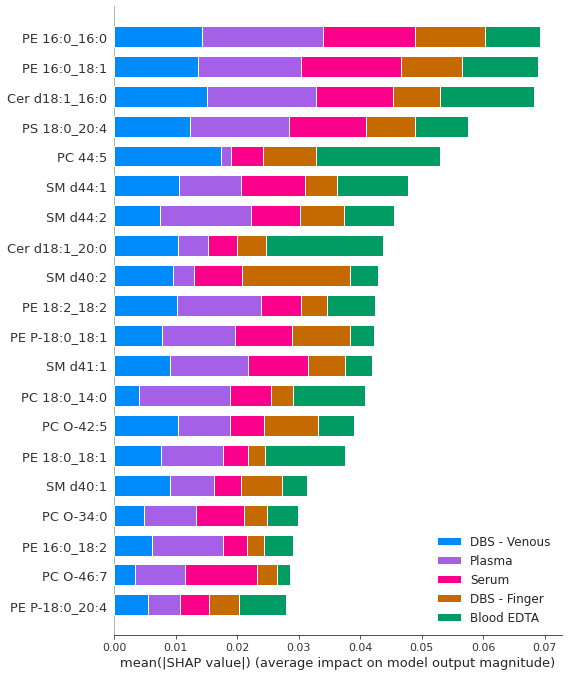

In [40]:
shap.summary_plot(list(shap_values[:,:,:]), lipid_x, plot_type="bar",
                  class_names=label_encoder.classes_, show=False)
plt.savefig(f'{classification_root_path}multiclass/multiclass_shap_bar.pdf')

## Visualise AUROC

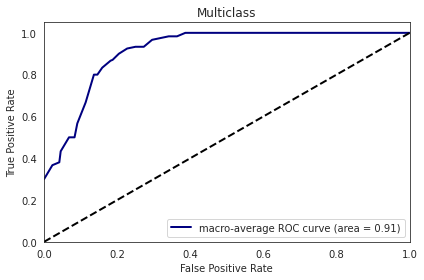

In [41]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    type_true = np.array([1 if y == i else 0 for y in all_true_multiclass])
    fpr[i], tpr[i], _ = roc_curve(type_true, np.array(all_prediction_multiclass)[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(label_encoder.classes_))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(label_encoder.classes_)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(label_encoder.classes_)
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle="-",
    linewidth=lw)

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Multiclass')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig(f'{classification_root_path}multiclass/multiclass_classifier.pdf')
plt.show()

## One vs. rest classification

In [21]:
all_true_ovr = []
all_prediction_ovr = []

outer_groups = lipid_data_df_without_na['Person']
list_shap_values_ovr = list()
list_test_sets_ovr = list()
mean_importance_list_ovr = list()
std_importance_list_ovr = list()

for one_type in range(len(label_encoder.classes_)):
    all_true_type = []
    all_prediction_group = []
    tmp_list_shap_values = list()
    tmp_list_test_sets = list()
    list_permutation_imortance = list()
    for train_index, test_index in logo.split(lipid_x, groups=outer_groups):
        ovr_blood_type = np.array([1 if y == one_type else 0 for y in blood_type])
        train_val_data = lipid_x.loc[train_index]
        test_data = lipid_x.loc[test_index]
        blood_type_test_val = ovr_blood_type[train_index]
        blood_type_test = ovr_blood_type[test_index]
        inner_groups = outer_groups.loc[train_index]
        grid_search = GridSearchCV(estimator = random_forest, param_grid = param_grid, 
                              cv = logo, n_jobs = -1, verbose = 1)
        clf = grid_search.fit(train_val_data, blood_type_test_val, groups = inner_groups)
        
        #explaining model
        explainer = shap.TreeExplainer(clf.best_estimator_)
        shap_values = explainer.shap_values(test_data)
        #for each iteration we save the test_set index and the shap_values
        tmp_list_shap_values.append(shap_values)
        tmp_list_test_sets.append(test_index)
        importance = permutation_importance(clf, test_data, blood_type_test)
        list_permutation_imortance.append(importance)
    
        # test stuff
        y_pred_proba = clf.predict_proba(test_data)
        y_pred = clf.predict(test_data)
        all_true_type.extend(blood_type_test)
        all_prediction_group.extend(y_pred_proba)
    
    list_shap_values_ovr.append(np.concatenate(tmp_list_shap_values,axis=1))
    list_test_sets_ovr.append(np.concatenate(tmp_list_test_sets, axis = 0))
    all_true_ovr.append(all_true_type)
    all_prediction_ovr.append(all_prediction_group)
    tmp = [permutation_imortance.importances_mean for permutation_imortance in list_permutation_imortance]
    mean_importance = np.mean(tmp, axis=0)
    tmp = [permutation_imortance.importances_std for permutation_imortance in list_permutation_imortance]
    std_importance = np.mean(tmp, axis=0)
    mean_importance_list_ovr.append(mean_importance)
    std_importance_list_ovr.append(std_importance)

ValueError: Found input variables with inconsistent numbers of samples: [24, 56]

## Permutation importance

In [43]:
for i in range(len(label_encoder.classes_)):
    mean_importance = mean_importance_list_ovr[i]
    std_importance = std_importance_list_ovr[i]
    forest_importances = pd.Series(mean_importance, index=lipid_x.keys())
    forest_sd = pd.Series(std_importance, index=lipid_x.keys())
    both = pd. concat([forest_importances, forest_sd], axis=1).sort_values(by=0, ascending=False)

    fig, ax = plt.subplots()
    both[0][:10].plot.bar(yerr=both[1], ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    plt.savefig(f'{classification_root_path}one_vs_rest/\
{label_encoder.inverse_transform([i])[0]}_vs_rest_permutation_importance.pdf')
    plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

## SHAP

In [44]:
for i in range(len(label_encoder.classes_)):
    shap_values = list_shap_values_ovr[i]
    test_set = list_test_sets_ovr[i]
    X = X_test = lipid_x.loc[test_set]
    shap.summary_plot(shap_values[1], X, show=False, max_display=10)
    plt.savefig(f'{classification_root_path}/one_vs_rest/{label_encoder.inverse_transform([i])[0]}\
    _vs_rest_shap_beeswarm.pdf')
    plt.clf()
    shap.summary_plot(list(shap_values[:,:,:]), X, plot_type="bar",
                  class_names=[label_encoder.inverse_transform([i])[0], 'Others'], show=False)
    plt.savefig(f'{classification_root_path}one_vs_rest/{label_encoder.inverse_transform([i])[0]}\
_vs_rest_shap_bar.pdf')
    plt.clf()

<Figure size 576x684 with 0 Axes>

## Visualise AUROC

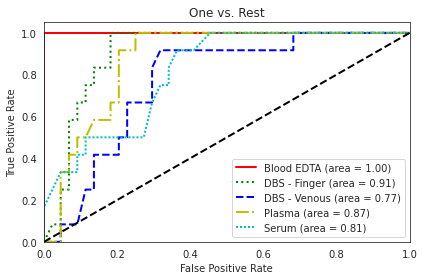

In [45]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(all_true_ovr[i], np.array(all_prediction_ovr[i])[:, 1])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], lw=lw,
        label=f"{label_encoder.inverse_transform([i])[0]} (area = {roc_auc[i]:0.2f})")


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(label_encoder.classes_))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(label_encoder.classes_)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(label_encoder.classes_)
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('One vs. Rest')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig(f'{classification_root_path}one_vs_rest/one_vs_rest_classifier.pdf')
plt.show()

## One vs. one classification

In [25]:
all_true_ovo_list = []
all_prediction_ovo_list = []


for one_type in trange(len(label_encoder.classes_)):
    all_true_type = []
    all_prediction_type = []

    for second_one_type in trange(len(label_encoder.classes_)):
        if one_type == second_one_type:
            all_true_type.append([])
            all_prediction_type.append([])
            continue
        d = {one_type: 1, second_one_type: 0}
        ovo_blood_type = np.array([d[y]  for y in blood_type if y in d])
        indices = np.nonzero(np.isin(blood_type, [one_type, second_one_type]))
        outer_groups = lipid_data_df_without_na.loc[indices[0]]['Person']
        lipid_x = lipid_data_df_without_na.loc[indices[0]].drop(columns=['Person', 'Blood Type', 'Date'])
        all_prediction_ovo = []
        all_true_ovo = []
        for train_index, test_index in logo.split(lipid_x, groups=outer_groups):
            train_val_data = lipid_x.iloc[train_index]
            test_data = lipid_x.iloc[test_index]
            blood_type_test_val = ovo_blood_type[train_index]
            blood_type_test = ovo_blood_type[test_index]
            inner_groups = outer_groups.iloc[train_index]
            grid_search = GridSearchCV(estimator = random_forest, param_grid = param_grid, 
                                  cv = logo, n_jobs = -1, verbose = 1)
            clf = grid_search.fit(train_val_data, blood_type_test_val, groups = inner_groups)

        
            # test stuff
            y_pred_proba = clf.predict_proba(test_data)
            y_pred = clf.predict(test_data)
            all_true_ovo.extend(blood_type_test)
            all_prediction_ovo.extend(y_pred_proba)
        all_true_type.append(all_true_ovo)
        all_prediction_type.append(all_prediction_ovo)
    all_true_ovo_list.append(all_true_type)
    all_prediction_ovo_list.append(all_prediction_type)

  0%|                                                                                        | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 40%|███████████████████████████████▌                                               | 2/5 [07:52<11:48, 236.32s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 60%|███████████████████████████████████████████████▍                               | 3/5 [16:03<11:24, 342.46s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 80%|███████████████████████████████████████████████████████████████▏               | 4/5 [23:29<06:20, 380.94s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



  0%|                                                                                        | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 20%|███████████████▊                                                               | 1/5 [07:35<30:20, 455.08s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 60%|███████████████████████████████████████████████▍                               | 3/5 [13:45<08:30, 255.35s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 80%|███████████████████████████████████████████████████████████████▏               | 4/5 [19:54<04:54, 294.49s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



  0%|                                                                                        | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 20%|███████████████▊                                                               | 1/5 [06:08<24:32, 368.15s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 40%|███████████████████████████████▌                                               | 2/5 [12:17<18:26, 368.68s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 80%|███████████████████████████████████████████████████████████████▏               | 4/5 [18:25<04:12, 252.89s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



  0%|                                                                                        | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 20%|███████████████▊                                                               | 1/5 [08:59<35:57, 539.25s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 40%|███████████████████████████████▌                                               | 2/5 [18:03<27:07, 542.45s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 60%|███████████████████████████████████████████████▍                               | 3/5 [27:48<18:43, 561.85s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



  0%|                                                                                        | 0/5 [00:00<?, ?it/s]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 20%|███████████████▊                                                               | 1/5 [06:53<27:35, 413.97s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 40%|███████████████████████████████▌                                               | 2/5 [14:38<22:11, 443.76s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



 60%|███████████████████████████████████████████████▍                               | 3/5 [22:27<15:10, 455.11s/it]

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits



100%|████████████████████████████████████████████████████████████████████████████| 5/5 [2:28:16<00:00, 1779.32s/it]


## Visualise AUROCS

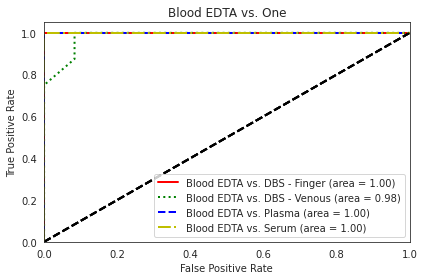

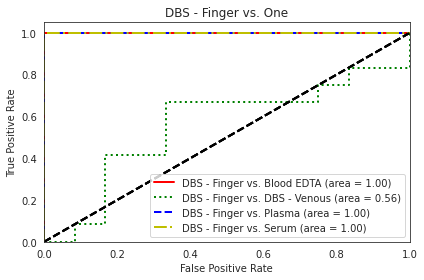

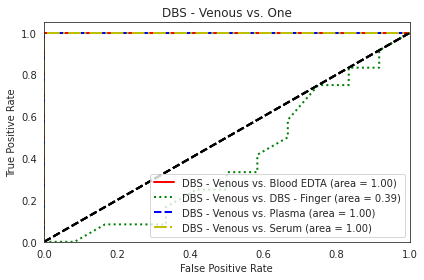

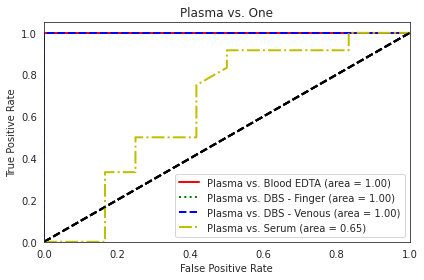

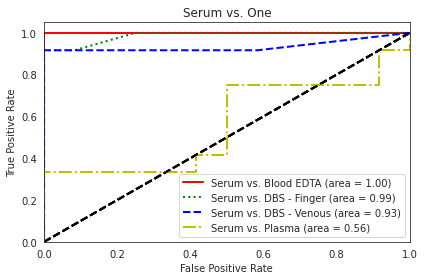

In [26]:
for one_type in range(len(label_encoder.classes_)):
    for second_one_type in range(len(label_encoder.classes_)):
        if one_type == second_one_type:
            continue
        all_true_ovo = all_true_ovo_list[one_type][second_one_type]
        all_prediction_ovo = all_prediction_ovo_list[one_type][second_one_type]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        lw = 2


        fpr, tpr, _ = roc_curve(all_true_ovo, np.array(all_prediction_ovo)[:,1])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=lw,
            label=f"{label_encoder.inverse_transform([one_type])[0]}"\
                 f" vs. {label_encoder.inverse_transform([second_one_type])[0]} (area = {roc_auc:0.2f})")

        plt.plot([0, 1], [0, 1], "k--", lw=lw)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title(f'{label_encoder.inverse_transform([one_type])[0]} vs. One')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
    plt.savefig(f'{classification_root_path}one_vs_one/\
{label_encoder.inverse_transform([one_type])[0]}_vs_one_classifier.pdf')
    plt.show()